In [11]:
!git clone https://github.com/JovanK26/EpiInfer.git

fatal: destination path 'EpiInfer' already exists and is not an empty directory.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [13]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Model parameters
INCUBATION_PERIOD = 7
FORECAST_DAYS = 1
TOTAL_DAYS = 101
NUM_COMPARTMENTS = 4  # S, E, I, R
NUM_GROUPS = 6
RECOVERY_RATE = 0.1
IMMUNITY_LOSS_RATE = 0.01

# Population data
AUSTRIA_POPULATION = 8_913_088
POPULATION_GROUPS = [0.887, 0.076, 0.019, 0.011, 0.004, 0.003]
CONTACTS_PER_GROUP = np.array([3, 8, 15, 35, 75, 100])

# Data paths
DATA_DIR = "EpiInfer/Data"
COUNTRY = "AT_"

In [14]:
# =============================================================================
# DATA INITIALIZATION
# =============================================================================

def initialize_population():
    """Initialize population arrays by contact group."""
    pop = np.zeros(NUM_GROUPS + 1)
    pop[0] = AUSTRIA_POPULATION
    for i in range(NUM_GROUPS):
        pop[i + 1] = AUSTRIA_POPULATION * POPULATION_GROUPS[i]
    return pop

def load_data(total_days):
    """Load epidemic data from CSV files."""
    data_dir = Path(DATA_DIR)
    cum_file = data_dir / f"{COUNTRY}datacumu.csv"
    daily_file = data_dir / f"{COUNTRY}datanew.csv"

    cum_df = pd.read_csv(cum_file, header=None)
    daily_df = pd.read_csv(daily_file, header=None)

    days = min(len(cum_df), total_days)

    # Initialize arrays: (day, compartment, group)
    cum_real = np.zeros((days, NUM_COMPARTMENTS, NUM_GROUPS + 1))
    daily_real = np.zeros((days, NUM_COMPARTMENTS, NUM_GROUPS + 1))

    # Load data
    for d in range(days):
        for c in range(min(cum_df.shape[1], NUM_COMPARTMENTS)):
            cum_real[d, c, 0] = cum_df.iloc[d, c]
            daily_real[d, c, 0] = daily_df.iloc[d, c]

            # Distribute across groups
            for g in range(NUM_GROUPS):
                cum_real[d, c, g + 1] = cum_real[d, c, 0] * POPULATION_GROUPS[g]
                daily_real[d, c, g + 1] = daily_real[d, c, 0] * POPULATION_GROUPS[g]

    return cum_real, daily_real, days

# =============================================================================
# SEIR MODEL
# =============================================================================

def simulate_seir(population, cum_real, daily_real, p1, p2, train_end):
    """Run SEIR epidemic simulation."""
    days = len(cum_real)
    cum_sim = np.zeros_like(cum_real)
    daily_sim = np.zeros_like(daily_real)

    # Initialize with real data
    cum_sim[:INCUBATION_PERIOD] = cum_real[:INCUBATION_PERIOD]
    daily_sim[:INCUBATION_PERIOD] = daily_real[:INCUBATION_PERIOD]

    for day in range(INCUBATION_PERIOD, days):
        simulate_day(day, population, cum_real, daily_real, cum_sim,
                    daily_sim, p1, p2, train_end)

    return cum_sim, daily_sim

def simulate_day(day, pop, cum_real, daily_real, cum_sim, daily_sim, p1, p2, train_end):
    """Simulate single day of epidemic."""
    inc = INCUBATION_PERIOD
    ng = NUM_GROUPS + 1

    # Calculate recent infections (past week)
    recent_inf = np.zeros(ng)
    for lag in range(1, inc + 1):
        if day - lag >= 0:
            data_source = daily_sim if day - lag >= train_end else daily_real
            recent_inf += data_source[day - lag, 2, :]

    # Get infected at t - incubation_period
    data_source = cum_sim if day - inc >= train_end else cum_real
    total_inf = data_source[day - inc, 2, :]

    asymptomatic = pop - total_inf

    # Calculate exposure and transmission probabilities
    p_exposure = recent_inf[0] / (p2 * asymptomatic[0])
    p_trans = np.ones(ng)
    for g in range(1, ng):
        p_trans[g] = 1 - (1 - p1) ** (CONTACTS_PER_GROUP[g - 1] * p_exposure)

    # Calculate susceptible population
    susceptible = asymptomatic - recent_inf / p2 - cum_sim[day - inc, 3, :]
    susceptible[1:] = np.maximum(susceptible[1:], 0)

    # New exposures
    new_exposed = np.zeros(ng)
    new_exposed[1:] = susceptible[1:] * p_trans[1:]
    new_exposed[0] = new_exposed[1:].sum()

    # Record with incubation delay
    if day - inc >= inc:
        daily_sim[day - inc, 1, :] = new_exposed

    # New infections, recoveries, immunity loss
    daily_sim[day, 2, :] = new_exposed * p2
    daily_sim[day, 3, :] = cum_sim[day - 1, 2, :] * RECOVERY_RATE
    daily_sim[day, 0, :] = cum_sim[day - 1, 3, :] * IMMUNITY_LOSS_RATE

    # Update cumulative counts
    cum_sim[day, 3, :] = cum_sim[day - 1, 3, :] - daily_sim[day, 0, :] + daily_sim[day, 3, :]
    cum_sim[day, 2, :] = cum_sim[day - 1, 2, :] + daily_sim[day, 2, :] - daily_sim[day, 3, :]

# =============================================================================
# PARAMETER OPTIMIZATION
# =============================================================================

def optimize_parameters(pop, cum_real, daily_real, train_end):
    """Optimize p1 and p2 parameters using grid + binary search."""
    best_p1, best_p2, best_rmse = -1, -1, np.inf

    # Grid search over p2
    for p2 in np.linspace(0.1, 1.0, 10):
        # Binary search for p1
        left, right = 0.0, 1.0

        while right - left > 0.0001:
            p1 = (left + right) / 2
            cum_sim, daily_sim = simulate_seir(pop, cum_real, daily_real, p1, p2, train_end)

            # Calculate residual at last training day
            residual = cum_sim[train_end - 1, 2, 0] - cum_real[train_end - 1, 2, 0]
            rmse = np.sqrt(residual ** 2)

            if rmse < best_rmse:
                best_p1, best_p2, best_rmse = p1, p2, rmse

            # Adjust search range
            if residual < 0:
                left = p1
            elif residual > 0:
                right = p1
            else:
                break

    return best_p1, best_p2

# =============================================================================
# FORECASTING EXPERIMENT
# =============================================================================

def run_forecast_experiment(train_days_range, forecast_days=10):
    """Run forecasting across different training periods."""
    results = []
    pop = initialize_population()

    for train_days in train_days_range:
        total_days = train_days + forecast_days + 1

        # Load data
        cum_real, daily_real, max_days = load_data(total_days)
        if max_days < total_days:
            continue

        # Training cutoff matches original code
        train_end = total_days - forecast_days

        # Optimize parameters
        p1, p2 = optimize_parameters(pop, cum_real, daily_real, train_end)

        # Run final simulation
        cum_sim, daily_sim = simulate_seir(pop, cum_real, daily_real, p1, p2, train_end)

        # Calculate metrics at forecast endpoint
        pred_day = total_days - 1
        pred_cases = cum_sim[pred_day, 2, 0]
        real_cases = cum_real[pred_day, 2, 0]
        rel_error = abs(pred_cases - real_cases) / real_cases

        results.append({
            'train_days': train_days,
            'forecast_day': pred_day,
            'predicted': pred_cases,
            'actual': real_cases,
            'rel_error': rel_error,
            'p1': p1,
            'p2': p2
        })

        print(f"Train: {train_days:2d} → Forecast: {pred_day:2d} | "
              f"Pred: {pred_cases:,.0f} | Actual: {real_cases:,.0f} | "
              f"Error: {rel_error:.4f} | p1={p1:.6f}, p2={p2:.1f}")

    return pd.DataFrame(results)

# =============================================================================
# VISUALIZATION
# =============================================================================

def plot_results(results_df):
    """Create comprehensive visualization with real vs predicted comparison."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Predicted vs Actual Cases
    axes[0, 0].plot(results_df['forecast_day'], results_df['predicted'],
                    'b-o', label='Predicted', markersize=3)
    axes[0, 0].plot(results_df['forecast_day'], results_df['actual'],
                    'r--s', label='Actual', markersize=3)
    axes[0, 0].set_xlabel('Forecast Day')
    axes[0, 0].set_ylabel('Cumulative Cases')
    axes[0, 0].set_title('Predicted vs Actual Cases')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # 2. Relative Error over Time
    axes[0, 1].plot(results_df['train_days'], results_df['rel_error'],
                    'g-o', markersize=4)
    axes[0, 1].set_xlabel('Training Days')
    axes[0, 1].set_ylabel('Relative Error')
    axes[0, 1].set_title('Forecast Error vs Training Period')
    axes[0, 1].grid(alpha=0.3)

    # 3. Prediction Accuracy (Predicted/Actual ratio)
    ratio = results_df['predicted'] / results_df['actual']
    axes[0, 2].plot(results_df['forecast_day'], ratio, 'm-o', markersize=3)
    axes[0, 2].axhline(y=1.0, color='k', linestyle='--', alpha=0.5)
    axes[0, 2].set_xlabel('Forecast Day')
    axes[0, 2].set_ylabel('Predicted / Actual Ratio')
    axes[0, 2].set_title('Prediction Accuracy Ratio')
    axes[0, 2].grid(alpha=0.3)

    # 4. Absolute Error
    abs_error = np.abs(results_df['predicted'] - results_df['actual'])
    axes[1, 0].plot(results_df['train_days'], abs_error, 'r-o', markersize=4)
    axes[1, 0].set_xlabel('Training Days')
    axes[1, 0].set_ylabel('Absolute Error (Cases)')
    axes[1, 0].set_title('Absolute Forecast Error')
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].ticklabel_format(style='plain', axis='y')

    # 5. Parameter Evolution
    ax = axes[1, 1]
    ax_twin = ax.twinx()
    ax.plot(results_df['train_days'], results_df['p1'],
            'b-o', label='p1', markersize=3)
    ax_twin.plot(results_df['train_days'], results_df['p2'],
                 'r-s', label='p2', markersize=3)
    ax.set_xlabel('Training Days')
    ax.set_ylabel('p1 (Transmission)', color='b')
    ax_twin.set_ylabel('p2 (Reporting)', color='r')
    ax.set_title('Optimal Parameters')
    ax.grid(alpha=0.3)
    ax.tick_params(axis='y', labelcolor='b')
    ax_twin.tick_params(axis='y', labelcolor='r')

    # 6. Error Distribution
    axes[1, 2].hist(results_df['rel_error'], bins=20, edgecolor='black', alpha=0.7)
    axes[1, 2].axvline(results_df['rel_error'].mean(), color='r',
                      linestyle='--', linewidth=2,
                      label=f"Mean: {results_df['rel_error'].mean():.4f}")
    axes[1, 2].set_xlabel('Relative Error')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Error Distribution')
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('seir_forecast_results.png', dpi=150, bbox_inches='tight')
    plt.show()

SEIR EPIDEMIC FORECASTING MODEL

Population: 8,913,088
Forecast horizon: 1 days
Training range: 10-90 days

Running forecasting experiment...

Train: 10 → Forecast: 11 | Pred: 90 | Actual: 79 | Error: 0.1459 | p1=0.042175, p2=1.0
Train: 11 → Forecast: 12 | Pred: 113 | Actual: 99 | Error: 0.1399 | p1=0.036377, p2=1.0
Train: 12 → Forecast: 13 | Pred: 138 | Actual: 111 | Error: 0.2467 | p1=0.031677, p2=1.0
Train: 13 → Forecast: 14 | Pred: 150 | Actual: 155 | Error: 0.0294 | p1=0.025208, p2=0.1
Train: 14 → Forecast: 15 | Pred: 208 | Actual: 248 | Error: 0.1637 | p1=0.026001, p2=0.1
Train: 15 → Forecast: 16 | Pred: 337 | Actual: 320 | Error: 0.0508 | p1=0.031128, p2=1.0
Train: 16 → Forecast: 17 | Pred: 435 | Actual: 470 | Error: 0.0751 | p1=0.029663, p2=0.1
Train: 17 → Forecast: 18 | Pred: 642 | Actual: 633 | Error: 0.0141 | p1=0.032043, p2=0.2
Train: 18 → Forecast: 19 | Pred: 866 | Actual: 768 | Error: 0.1276 | p1=0.031616, p2=0.1
Train: 19 → Forecast: 20 | Pred: 1,040 | Actual: 917 | Erro

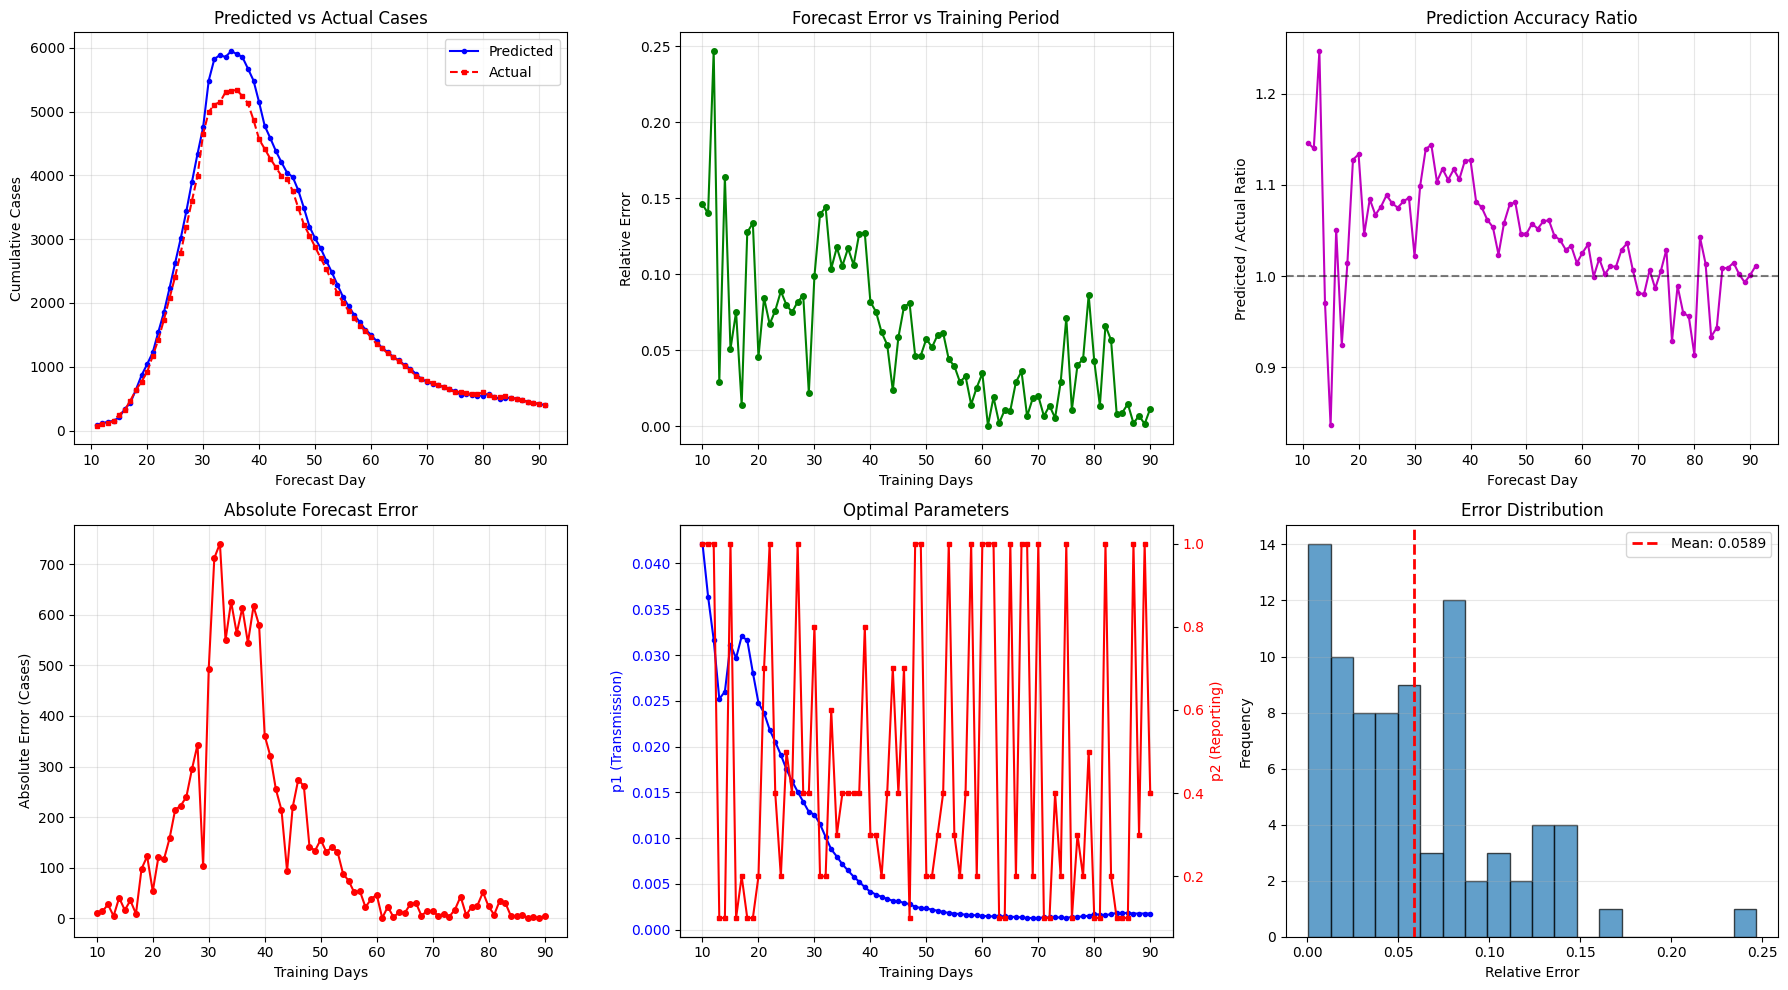

✓ Plots saved to 'seir_forecast_results.png'


In [15]:
# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    print("="*70)
    print("SEIR EPIDEMIC FORECASTING MODEL")
    print("="*70)

    # Setup
    print(f"\nPopulation: {AUSTRIA_POPULATION:,}")
    print(f"Forecast horizon: {FORECAST_DAYS} days")
    print(f"Training range: 10-90 days\n")

    # Run experiment
    print("Running forecasting experiment...\n")
    results_df = run_forecast_experiment(range(10, 91), FORECAST_DAYS)

    # Summary statistics
    print("\n" + "="*70)
    print("RESULTS SUMMARY")
    print("="*70)
    print(f"Experiments run: {len(results_df)}")
    print(f"Avg relative error: {results_df['rel_error'].mean():.4f}")
    print(f"Std relative error: {results_df['rel_error'].std():.4f}")
    print(f"Min relative error: {results_df['rel_error'].min():.4f}")
    print(f"Max relative error: {results_df['rel_error'].max():.4f}")
    print(f"\nParameter ranges:")
    print(f"  p1: {results_df['p1'].min():.4f} - {results_df['p1'].max():.4f}")
    print(f"  p2: {results_df['p2'].min():.2f} - {results_df['p2'].max():.2f}")

    # Prediction accuracy
    avg_ratio = (results_df['predicted'] / results_df['actual']).mean()
    print(f"\nAverage prediction ratio (pred/actual): {avg_ratio:.4f}")

    # Save results
    results_df.to_csv('seir_results.csv', index=False)
    print("\n✓ Results saved to 'seir_results.csv'")

    # Visualize
    print("✓ Generating plots...")
    plot_results(results_df)
    print("✓ Plots saved to 'seir_forecast_results.png'")